In [ ]:
!pip install flash-attn --no-build-isolation
!pip install urllib3==1.26.15 tiktoken==0.4.0

In [ ]:
import os
from IPython.display import HTML
import unstructured
from unstructured.partition.pdf import partition_pdf
import torch
import time
import re
from bs4 import BeautifulSoup
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core import Settings
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.core import PromptTemplate

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [ ]:
contract_dir= "pharmacy_contracts"
# text_filepath = os.path.join(contract_dir, "tables_textfiles")
filenames = [fname for fname in os.listdir(contract_dir) if ".pdf" in fname]
print("Number of files- ", len(filenames))

Number of files-  3


## Approach using multiple pdf documents

In [ ]:
def get_pdf_elements(contract_dir, filenames):
  t1= time.time()
  elements= []
  for fname in filenames:
    filepath = os.path.join(contract_dir, fname)
    print("Loading pdf filename: ",filepath)
    new_elements = partition_pdf(filename=filepath,
                                strategy="hi_res",
                                infer_table_structure=True,
                                languages=["eng"])
    elements.extend(new_elements)
  print(f"\n___\nTotal partioning time for {len(filenames)} files : {time.time()-t1}\n___\n")
  return elements

def export_text_file(select_content_from_tables, contract_dir= "pharmacy_contracts", saved_filename="tables_textfiles.txt"):
  text_filepath= os.path.join(contract_dir, "tables_textfiles")
  text=""
  if not os.path.exists(text_filepath):
    print(f"{text_filepath} doesn't exist!\nCreating now. .")
    os.mkdir(text_filepath)
  output_file_path= os.path.join(text_filepath, saved_filename)
  with open(output_file_path, 'w', encoding='utf-8') as text_file:# Save the extracted metadata to text file
    text+=str(select_content_from_tables)
    text_file.write(text)
    text_file.close()
    print(f"\n___\nSaving textfile: {output_file_path}!\n")

In [ ]:
def get_tables_from_pdf(contract_dir, save_as_text_file=True, saved_filename="tables_textfiles.txt"):
  filenames = [fname for fname in os.listdir(contract_dir) if ".pdf" in fname]
  elements= get_pdf_elements(contract_dir, filenames)
  select_content_from_tables= []
  for i, page in enumerate(elements):# Iterating over elements loaded through regular partition method
    if isinstance(page, unstructured.documents.elements.Table):
      print(f"Element at Index: {i}: with page_number: {page.metadata.page_number} contains a 'table'")# Signatures from page# 8
      page= page.to_dict()# Converts 'Table' type object to regular dictionary
      select_content_from_tables.append((page.get("metadata").get("filename"), page.get("metadata").get("text_as_html"),
                                         page.get("text")))# Collect metadata from 'Table' dict
      # select_content_from_tables.append((page.get("metadata").get("filename"),
      #                                 page.get("text")))
  if save_as_text_file:
    export_text_file(select_content_from_tables, contract_dir, saved_filename=saved_filename)

  return select_content_from_tables

In [ ]:

select_content_from_tables= get_tables_from_pdf(contract_dir= "pharmacy_contracts",
                                                saved_filename="tables_from_3_textfiles.txt")


Loading pdf filename:  pharmacy_contracts/fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf


Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Loading pdf filename:  pharmacy_contracts/Countersigned IU Health IDN Access INJ CER 2021-06-22 v4_IUH 07.08.2021_Pfizer 09.28.2021 Clean.pdf
Loading pdf filename:  pharmacy_contracts/fully executed_Amendment to 11854 Tier Overlay and Extension.pdf

___
Total partioning time for 3 files : 682.7155692577362
___

Element at Index: 95: with page_number: 9 contains a 'table'
Element at Index: 110: with page_number: 10 contains a 'table'
Element at Index: 317: with page_number: 18 contains a 'table'
Element at Index: 322: with page_number: 19 contains a 'table'
Element at Index: 327: with page_number: 20 contains a 'table'
Element at Index: 332: with page_number: 21 contains a 'table'
Element at Index: 337: with page_number: 22 contains a 'table'
Element at Index: 342: with page_number: 23 contains a 'table'
Element at Index: 367: with page_number: 24 contains a 'table'
Element at Index: 388: with page_number: 25 contains a 'table'
Element at Index: 393: with page_number: 26 contains a 'tab

In [ ]:
# select_content_from_tables
def extract_ndc_and_price(input_list):
    output_list = []

    # Regex patterns
    ndc_pattern = re.compile(r'\b\d{10,12}\b')
    price_pattern = re.compile(r'\$\d+(\.\d{1,2})?')

    for file_name, html_table, text_table in input_list:
        soup = BeautifulSoup(html_table, 'html.parser')
        rows = soup.find_all('tr')

        for row in rows:
            cells = row.find_all('td')
            if len(cells) > 1:
                ndc_number = None
                price = None

                for cell in cells:
                    cell_text = cell.get_text(strip=True)
                    # Search for NDC number
                    if ndc_pattern.search(cell_text):
                        ndc_number = ndc_pattern.search(cell_text).group()
                    # Search for price
                    if price_pattern.search(cell_text):
                        price = price_pattern.search(cell_text).group()

                if ndc_number and price:
                    output_list.append((file_name, ndc_number, price))

    return output_list

In [ ]:
input_list = select_content_from_tables#[select_content_from_tables[1]]

output = extract_ndc_and_price(input_list)
print(output)

[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '63323026929', '$22.50'), ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '63323026950', '$112.20'), ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '63323026965', '$112.10'), ('fully executed_Amendment to 11854 Tier Overlay and Extension.pdf', '63323009330', '$90')]


In [ ]:
system_prompt = """<|SYSTEM|>You are a Q&A assistant Expert in analyzing legal contracts.
<|end|>\n
"""

query_wrapper_prompt= ("<|SYSTEM|>\n"
"You are a Q&A assistant Expert in analyzing legal contracts<|end|>\n"
"<|user|>\n"
"{query_str}<|end|>\n"
"<|assistant|>\n")
llm = HuggingFaceLLM(
    context_window=8192,
    max_new_tokens=512,# Increase this to 4096
    # attn_implementation="eager",
    generate_kwargs={"temperature": 0.1, "do_sample": True},
    # generate_kwargs={"temperature": 0.7, "do_sample": False},
    system_prompt=system_prompt,
    query_wrapper_prompt=query_wrapper_prompt,
    tokenizer_name="microsoft/Phi-3-small-8k-instruct",
    model_name="microsoft/Phi-3-small-8k-instruct",
    device_map="auto",
    # stopping_ids=[50278, 50279, 50277, 1, 0],
    tokenizer_kwargs={"max_length": 8192},
    # uncomment this if using CUDA to reduce memory usage
    model_kwargs={"torch_dtype": torch.float16})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for microsoft/Phi-3-small-8k-instruct contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/microsoft/Phi-3-small-8k-instruct.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
The repository for microsoft/Phi-3-small-8k-instruct contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/microsoft/Phi-3-small-8k-instruct.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


ConnectTimeout: HTTPSConnectionPool(host='openaipublic.blob.core.windows.net', port=443): Max retries exceeded with url: /encodings/cl100k_base.tiktoken (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x7d4dc9203a60>, 'Connection to openaipublic.blob.core.windows.net timed out. (connect timeout=None)'))

In [ ]:
# !pip3 install --force-reinstall --pre torch torchtext torchvision torchaudio torchrec --extra-index-url https://download.pytorch.org/whl/nightly/cu121

In [ ]:
Settings.llm = llm
Settings.chunk_size = 512
embed_model = FastEmbedEmbedding(model_name="BAAI/bge-small-en-v1.5")
Settings.embed_model = embed_model
Settings.chunk_size = 512

In [ ]:
documents = SimpleDirectoryReader(text_filepath).load_data()
index = VectorStoreIndex.from_documents(documents, show_progress=True)
query_engine = index.as_query_engine()

## Approach using single pdf document

In [ ]:
filepath = os.path.join(contract_dir, filenames[0])
print("Loading pdf filename: ",filepath)
new_elements = partition_pdf(filename=filepath,
                             strategy="hi_res",
                             infer_table_structure=True,
                             languages=["eng"])# Loads a pdf file from 'filepath'

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Loading pdf filename:  pharmacy_contracts/fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf


Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
select_pages_with_tables= []
select_content_from_tables= []
for i, page in enumerate(new_elements):# Iterating over elements loaded through regular partition method
  if isinstance(page, unstructured.documents.elements.Table):
    # v=n
    select_pages_with_tables.append(page)# Picks only elements of 'Table' type
    print(f"Element at Index: {i}: with page_number: {page.metadata.page_number} contains a 'table'")# Signatures from page# 8
    page= page.to_dict()# Converts 'Table' type object to regular dictionary
    # select_content_from_tables.append((page.get("metadata").get("filename"), page.get("metadata").get("text_as_html"),
    #                                    page.get("text")))# Collect metadata from 'Table' dict
    select_content_from_tables.append((page.get("metadata").get("filename"),
                                     page.get("text")))

# text_as_html = page.get("metadata").get("text_as_html")# Visualize one of the table from select above
# display(HTML(text_as_html))

text=""
if not os.path.exists(text_filepath):
  print(f"{text_filepath} doesn't exist!\nCreating now. .")
  os.mkdir(text_filepath)
output_file_path= os.path.join(text_filepath, "tables_textfiles.txt")
with open(output_file_path, 'w', encoding='utf-8') as text_file:# Save the extracted metadata to text file
  text+=str(select_content_from_tables)
  text_file.write(text)
  text_file.close()
  print(f"Saving textfile: {output_file_path}")

Element at Index: 95: with page_number: 9 contains a 'table'
Element at Index: 110: with page_number: 10 contains a 'table'
Saving textfile: pharmacy_contracts/tables_textfiles/tables_textfiles.txt


In [ ]:
text_filepath= os.path.join(contract_dir, "tables_textfiles")
text_filepath

'pharmacy_contracts/tables_textfiles'

In [ ]:
system_prompt = """<|SYSTEM|>You are a Q&A assistant Expert in analyzing legal contracts.
<|end|>\n
"""

query_wrapper_prompt= ("<|SYSTEM|>\n"
"You are a Q&A assistant Expert in analyzing legal contracts<|end|>\n"
"<|user|>\n"
"{query_str}<|end|>\n"
"<|assistant|>\n")
llm = HuggingFaceLLM(
    context_window=4096,
    max_new_tokens=512,# Increase this to 4096
    generate_kwargs={"temperature": 0.7, "do_sample": True},
    # generate_kwargs={"temperature": 0.7, "do_sample": False},
    system_prompt=system_prompt,
    query_wrapper_prompt=query_wrapper_prompt,
    tokenizer_name="microsoft/Phi-3-mini-4k-instruct",
    model_name="microsoft/Phi-3-mini-4k-instruct",
    device_map="auto",
    # stopping_ids=[50278, 50279, 50277, 1, 0],
    tokenizer_kwargs={"max_length": 4096},
    # uncomment this if using CUDA to reduce memory usage
    model_kwargs={"torch_dtype": torch.float16})
Settings.llm = llm
Settings.chunk_size = 512
embed_model = FastEmbedEmbedding(model_name="BAAI/bge-small-en-v1.5")
Settings.embed_model = embed_model
Settings.chunk_size = 512
documents = SimpleDirectoryReader(text_filepath).load_data()
index = VectorStoreIndex.from_documents(documents, show_progress=True)
query_engine = index.as_query_engine()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

For your reference, The National Drug Code (NDC) is a unique identifier for medications approved by the FDA, structured in an 11-digit format (5-4-2). NDCs may appear in 10-digit formats on packaging, requiring conversion to 11 digits by inserting zeros:
4-4-2 to 5-4-2: Add a leading zero (e.g., 0002-7597-01 to 00002-7597-01).
5-3-2 to 5-4-2: Insert a zero in the middle (e.g., 50242-040-62 to 50242-0040-62).
5-4-1 to 5-4-2: Append a zero at the end (e.g., 60575-4112-1 to 60575-4112-01).
NDCs typically contain hyphens for readability but should be entered without them. To identify NDCs, look for sequences matching the 5-4-2 format and apply conversion rules to 10-digit formats, ensuring they correspond to the medication’s labeler, product, and package codes.

In [ ]:
# 1. Uses the updated text document with (filename, table text) to query and fetch all input records without any mofification

query= """I provided you a text document that contains products and pricing details in list of tuples in format - [(filename, HTML_table_as_text, table_as_text), . . ., (filename, HTML_table_as_text_3, table_as_text_3)].
First tell me the length of the list(list of tuples) in the document, then I want you to return the complete input text from the document AS IT IS with NO MODIFICATIONS or change of format in it."""
print(f"\nInput query: {query}\n_____\n",)

response = query_engine.query(query)
print(response)


Input query: I provided you a text document that contains products and pricing details in list of tuples in format - [(filename, HTML_table_as_text, table_as_text), . . ., (filename, HTML_table_as_text_3, table_as_text_3)].
First tell me the length of the list(list of tuples) in the document, then I want you to return the complete input text from the document AS IT IS with NO MODIFICATIONS or change of format in it.
_____

The length of the list of tuples in the document is 2.

Here is the complete input text from the document AS IT IS with NO MODIFICATIONS or change of format:

[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', 'FK Account # Facility Name 600929 IU Health Ball Memorial 600066 IU Health Bloomington 70385001 IU Health Methodist 403914 IU Health Saxony 400528016 IU Health Shared Services Pharmacy 66279601 IU Health University 736370 Riley Hospital for Children at IU Health 40052807 IU Health Hem Onc - East Pharmacy 40052808 IU He

In [ ]:
#2. Uses the updated text document with (filename, table text) to query and fetch all input records with NDC numbers and prices, without any mofification
query= """I provided you a text document that contains products and pricing details in list of tuples in format - [(filename, HTML_table_as_text, table_as_text), . . .,(filename, HTML_table_as_text_3, table_as_text_3)].
I want you to check second index in each tuple of the list and return ONLY THOSE tuples that contain any details related to National Drug Code ('NDC Number' or 'NDC Code') of products and their prices(in Dollars with $ prefix) from the document AS IT IS with NO MODIFICATIONS or change of format in it."""
print(f"\nInput query: {query}\n_____\n",)

response = query_engine.query(query)
print(response)


Input query: I provided you a text document that contains products and pricing details in list of tuples in format - [(filename, HTML_table_as_text, table_as_text), . . .,(filename, HTML_table_as_text_3, table_as_text_3)].
I want you to check second index in each tuple of the list and return ONLY THOSE tuples that contain any details related to National Drug Code ('NDC Number' or 'NDC Code') of products and their prices(in Dollars with $ prefix) from the document AS IT IS with NO MODIFICATIONS or change of format in it.
_____

[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', 'Product Code NDC Number Product Description Contract Affected 260929 260950 260965 63323026929 Diprivan® 10mg/mL 1% 20mL SDV 10 Pack 63323026950 Diprivan® 10mg/mL 1% 50mL SDV 63323026965 Diprivan® 10mg/mL 1% 100mL SDV *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC PK Size 10 20 10 Price / Each Price / PK $2.25 $22.50 $5.61 $11.21 $112.10'

In [ ]:
firstpass_text = response.response
firstpass_text

"[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', 'Product Code NDC Number Product Description Contract Affected 260929 260950 260965 63323026929 Diprivan® 10mg/mL 1% 20mL SDV 10 Pack 63323026950 Diprivan® 10mg/mL 1% 50mL SDV 63323026965 Diprivan® 10mg/mL 1% 100mL SDV *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC PK Size 10 20 10 Price / Each Price / PK $2.25 $22.50 $5.61 $11.21 $112.10')]"

NDC : a unique identifier for medications approved by the FDA, structured in an 11-digit format (5-4-2) or sometimes in 10-digit format (5-3-2).
NDCs typically contain hyphens for readability but they can also be found without hyphens. To identify NDCs, look for 10 to 11-digit format sequences matching the 5-4-2 or 5-3-2 format.



In [ ]:
# #3. Uses the output response from above prompt which contains only relevant table text (filename, table text) to query and fetch all only select data values like NDC numbers and prices from input text.
# query= f"""Now using this text - "{firstpass_text}" as an input context with format - [(filename1.pdf, table_as_text), . . .,(filename2.txt, table_as_text_3)].
# I want you to check second index in each tuple of the list and return ONLY these 2 details from each tuple as list of tuples - 1. National Drug Code ('NDC Number' or 'NDC Code' with 10 to 12 digits), 2. Price (in Dollars with $ prefix) from the document AS IT IS with NO MODIFICATIONS.

# Note, 'NDC Number' is a unique identifier for medications approved by the FDA, structured in a 10-digit to 12-digit format (10-digit 5-3-2, 11-digit 5-4-2 and 12-digit format 5-4-3). NDCs typically contain hyphens for readability but can also be found without hyphens. To identify NDCs, look for 10 to 12-digit format sequences matching the 5-4-2, 5-3-2 or 5-3-3 formats.

# You must return the output as list of tuples, with each tuple containing EXACTLY 3 values -  1. 'file_name' from input tuple's first index, 2. NDC Number(MUST BE A NUMBER with 10 to 12 digits) of each product/item from input tuple's second index, 3. Price of each item(in Dollars with $ prefix) from input tuple's second index.
# Here is what an example output from you should look like - [(filename_abc.txt, 662324999910, $15), (filename_abc.txt, 302324999911, $17). . .(filename_xyz.txt, 12232496710, $21)].
# """
# print(f"\nInput query: {query}\n_____\n",)

# response = query_engine.query(query)
# print(response)


Input query: Now using this text - "[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', 'Product Code NDC Number Product Description Contract Affected 260929 260950 260965 63323026929 Diprivan® 10mg/mL 1% 20mL SDV 10 Pack 63323026950 Diprivan® 10mg/mL 1% 50mL SDV 63323026965 Diprivan® 10mg/mL 1% 100mL SDV *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC PK Size 10 20 10 Price / Each Price / PK $2.25 $22.50 $5.61 $11.21 $112.10')]" as an input context of format - [(filename, table_as_text), . . .,(filename, table_as_text_3)].
I want you to check second index in each tuple of the list and return ONLY these 2 details from each tuple as list of tuples - 1. National Drug Code ('NDC Number' or 'NDC Code' with 11 to 12 digits), 2. Price (in Dollars with $ prefix) from the document AS IT IS with NO MODIFICATIONS.

Note, 'NDC Number' is a unique identifier for medications approved by the FDA, structured in an 11-digit forma

In [ ]:
#3. Uses the output response from above prompt which contains only relevant table text (filename, table text) to query and fetch all only select data values like NDC numbers and prices from input text.
query= f"""Now using this text - "{firstpass_text}" as an input context with format - [(filename1.pdf, table_as_text), . . .,(filename2.txt, table_as_text_3)].
I want you to check second index in each tuple of the list and return ONLY these 2 details from each tuple as list of tuples - 1. National Drug Code ('NDC Number' or 'NDC Code' with 10 to 12 digits), 2. Price (in Dollars with $ prefix) from the document AS IT IS with NO MODIFICATIONS.

Note, 'NDC Number' is a unique identifier for medications approved by the FDA, structured in a 10-digit to 12-digit format (10-digit 5-3-2, 11-digit 5-4-2 and 12-digit format 5-4-3). NDCs typically contain hyphens for readability but can also be found without hyphens. To identify NDCs, look for 10 to 12-digit format sequences matching the 5-4-2, 5-3-2 or 5-3-3 formats.

You must return the output as list of tuples, with each tuple containing EXACTLY 3 values -  1. 'file_name' from input tuple's first index, 2. NDC Number(MUST BE A NUMBER with 10 to 12 digits) of each product/item from input tuple's second index, 3. Price of each item(in Dollars with $ prefix) from input tuple's second index.
Here is what an example output from you should look like - [(filename_abc.txt, 662324999910, $15), (filename_abc.txt, 302324999911, $17). . .(filename_xyz.txt, 12232496710, $21)].
"""
print(f"\nInput query: {query}\n_____\n",)

response = query_engine.query(query)
print(response)


Input query: Now using this text - "[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', 'Product Code NDC Number Product Description Contract Affected 260929 260950 260965 63323026929 Diprivan® 10mg/mL 1% 20mL SDV 10 Pack 63323026950 Diprivan® 10mg/mL 1% 50mL SDV 63323026965 Diprivan® 10mg/mL 1% 100mL SDV *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC PK Size 10 20 10 Price / Each Price / PK $2.25 $22.50 $5.61 $11.21 $112.10')]" as an input context with format - [(filename1.pdf, table_as_text), . . .,(filename2.txt, table_as_text_3)].
I want you to check second index in each tuple of the list and return ONLY these 2 details from each tuple as list of tuples - 1. National Drug Code ('NDC Number' or 'NDC Code' with 10 to 12 digits), 2. Price (in Dollars with $ prefix) from the document AS IT IS with NO MODIFICATIONS.

Note, 'NDC Number' is a unique identifier for medications approved by the FDA, structured in a 10-

In [ ]:
firstpass_text

"[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', 'Product Code NDC Number Product Description Contract Affected 260929 260950 260965 63323026929 Diprivan® 10mg/mL 1% 20mL SDV 10 Pack 63323026950 Diprivan® 10mg/mL 1% 50mL SDV 63323026965 Diprivan® 10mg/mL 1% 100mL SDV *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC PK Size 10 20 10 Price / Each Price / PK $2.25 $22.50 $5.61 $11.21 $112.10')]"

In [ ]:
firstpass_text= """[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', 'Product Code NDC Number Product Description Contract Affected 260929 260950 260965 63323026929 Diprivan® 10mg/mL 1% 20mL SDV 10 Pack 63323026950 Diprivan® 10mg/mL 1% 50mL SDV 63323026965 Diprivan® 10mg/mL 1% 100mL SDV *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC PK Size 10 20 10 Price / Each Price / PK $2.25 $22.50 $5.61 $11.21 $112.10')]"""
firstpass_text

"[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', 'Product Code NDC Number Product Description Contract Affected 260929 260950 260965 63323026929 Diprivan® 10mg/mL 1% 20mL SDV 10 Pack 63323026950 Diprivan® 10mg/mL 1% 50mL SDV 63323026965 Diprivan® 10mg/mL 1% 100mL SDV *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC PK Size 10 20 10 Price / Each Price / PK $2.25 $22.50 $5.61 $11.21 $112.10')]"

* Following code tests if the first pass text when given in general instruct settings directly to phi-3, Does it perform better than it does in case of RAG.

In [ ]:
import torch
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core import Settings
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.core import PromptTemplate
# from huggingface_hub.hf_api import HfFolder
from llama_index.core import PromptTemplate
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# From phi-3 documentation

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer)

generation_args = {
    "max_new_tokens": 512,
    "return_full_text": False,
    "temperature": 0.1,
    "do_sample": False,
}

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
messages = [
    {"role": "user", "content": query},
]
output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

### Using REGEX to extract relevant text

In [ ]:
select_pages_with_tables= []
select_content_from_tables= []
for i, page in enumerate(new_elements):# Iterating over elements loaded through regular partition method
  if isinstance(page, unstructured.documents.elements.Table):
    # v=n
    select_pages_with_tables.append(page)# Picks only elements of 'Table' type
    print(f"Element at Index: {i}: with page_number: {page.metadata.page_number} contains a 'table'")# Signatures from page# 8
    page= page.to_dict()# Converts 'Table' type object to regular dictionary
    select_content_from_tables.append((page.get("metadata").get("filename"), page.get("metadata").get("text_as_html"),
                                       page.get("text")))# Collect metadata from 'Table' dict

Element at Index: 95: with page_number: 9 contains a 'table'
Element at Index: 110: with page_number: 10 contains a 'table'


In [ ]:
import re
from bs4 import BeautifulSoup

input_list = [select_content_from_tables[1]]

def extract_ndc_and_price(input_list):
    output_list = []

    # Regex patterns
    ndc_pattern = re.compile(r'\b\d{10,12}\b')
    price_pattern = re.compile(r'\$\d+(\.\d{1,2})?')

    for file_name, html_table, text_table in input_list:
        soup = BeautifulSoup(html_table, 'html.parser')
        rows = soup.find_all('tr')

        for row in rows:
            cells = row.find_all('td')
            if len(cells) > 1:
                ndc_number = None
                price = None

                for cell in cells:
                    cell_text = cell.get_text(strip=True)
                    # Search for NDC number
                    if ndc_pattern.search(cell_text):
                        ndc_number = ndc_pattern.search(cell_text).group()
                    # Search for price
                    if price_pattern.search(cell_text):
                        price = price_pattern.search(cell_text).group()

                if ndc_number and price:
                    output_list.append((file_name, ndc_number, price))

    return output_list

# Example usage
output = extract_ndc_and_price(input_list)
print(output)


[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '63323026929', '$22.50'), ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '63323026950', '$112.20'), ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '63323026965', '$112.10')]


In [ ]:
output = extract_ndc_and_price(select_content_from_tables)
print(output)

[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '63323026929', '$22.50'), ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '63323026950', '$112.20'), ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '63323026965', '$112.10')]


In [ ]:
"{"prod": ["12131", "213187"]}"

In [ ]:
BeautifulSoup(input_list[0][1], 'html.parser')

<table><tr><td rowspan="2">Product Code 260929 |</td><td>NDC Number</td><td></td><td>se Product Description</td><td>Contract Affected</td><td>PK | Size</td><td>Price/ | | Each</td><td>Price / PK</td></tr><tr><td></td><td>63323026929</td><td>Diprivan®</td><td>10mg/mL 1% 20mL SDV_ | 10 Pack</td><td>*New* Indiana University Health Sub WAC</td><td>10</td><td>$2.25 |</td><td>$22.50</td></tr><tr><td>260950 |</td><td>63323026950 |</td><td>a Diprivan®</td><td>9 10mg/mL 1% 50mL SDV</td><td>*New* Indiana University Health Sub WAC</td><td>20</td><td>$5.61 |</td><td>$112.20</td></tr><tr><td>260965 |</td><td>63323026965 |</td><td>a Diprivan®</td><td>9 10mg/mL 1% 100mL SDV</td><td>*New* Indiana University Health Sub WAC</td><td>10</td><td>$11.21</td><td>| $112.10</td></tr></table>

In [ ]:
# Converting the HTML table python dictionary

# input_list[0][1]
# def parse_html_table_to_dict(html):
#     soup = BeautifulSoup(html, 'html.parser')
#     table = soup.find('table')

#     headers = [header.get_text(strip=True) for header in table.find_all('th')]  # Extract headers
#     headers = [header if header else 'Unnamed' for header in headers]  # Handle unnamed headers

#     rows = table.find_all('tr')
#     if not headers:
#         headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]  # Use the first row as headers if no <th> tags

#     data = {header: [] for header in headers}

#     for row in rows[1:]:  # Skip the header row
#         cells = row.find_all('td')
#         for i, cell in enumerate(cells):
#             # Ensure to not go out of range for columns
#             if i < len(headers):
#                 data[headers[i]].append(cell.get_text(strip=True))

#     return data

def parse_html_table_to_dict(html):
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table')

    # Extract headers
    header_row = table.find('tr')
    headers = [header.get_text(strip=True) for header in header_row.find_all('td')]

    # Initialize the dictionary with headers as keys and empty lists as values
    data = {header: [] for header in headers}

    # Process each row, skipping the header row
    for row in table.find_all('tr')[1:]:
        cells = row.find_all('td')
        for header, cell in zip(headers, cells):
            cell_text = cell.get_text(strip=True).replace('|', '').strip()
            data[header].append(cell_text)

    return data

html_table = input_list[0][1]
parsed_data = parse_html_table_to_dict(html_table)
print(parsed_data)


{'Product Code 260929 |': ['', '260950', '260965'], 'NDC Number': ['63323026929', '63323026950', '63323026965'], '': ['Diprivan®', 'a Diprivan®', 'a Diprivan®'], 'se Product Description': ['10mg/mL 1% 20mL SDV_  10 Pack', '9 10mg/mL 1% 50mL SDV', '9 10mg/mL 1% 100mL SDV'], 'Contract Affected': ['*New* Indiana University Health Sub WAC', '*New* Indiana University Health Sub WAC', '*New* Indiana University Health Sub WAC'], 'PK | Size': ['10', '20', '10'], 'Price/ | | Each': ['$2.25', '$5.61', '$11.21'], 'Price / PK': ['$22.50', '$112.20', '$112.10']}


In [ ]:
# From previous 'parse_html_table_to_dict' implementation

# parsed_data = parse_html_table_to_dict(html_table)
# print(parsed_data)

{'Product Code 260929 |': ['', '260950 |', '260965 |'], 'NDC Number': ['63323026929', '63323026950 |', '63323026965 |'], '': ['Diprivan®', 'a Diprivan®', 'a Diprivan®'], 'se Product Description': ['10mg/mL 1% 20mL SDV_ | 10 Pack', '9 10mg/mL 1% 50mL SDV', '9 10mg/mL 1% 100mL SDV'], 'Contract Affected': ['*New* Indiana University Health Sub WAC', '*New* Indiana University Health Sub WAC', '*New* Indiana University Health Sub WAC'], 'PK | Size': ['10', '20', '10'], 'Price/ | | Each': ['$2.25 |', '$5.61 |', '$11.21'], 'Price / PK': ['$22.50', '$112.20', '| $112.10']}


________
## Ignore everything below this

In [ ]:
# !sudo apt-get update
# !apt-get install poppler-utils
# !apt install pkg-config tesseract-ocr

# !apt-get install tesseract-ocr libtesseract-dev libleptonica-dev pkg-config
# !pip install tesserocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 16.1 MB/s eta 0:00:00


In [ ]:
# !pip install jpype1
# !pip install tabula-py
# !pip install python-libmagic
# !pip install poppler-utils
# !pip install tesseract-ocr
# !pip install unstructured
# !pip install "unstructured[pdf]"
# !pip install pdf2image pillow
# !ls pharmacy_contracts/

import os
from IPython.display import HTML
from pdf2image import convert_from_path
from PIL import Image
import matplotlib.pyplot as plt
import unstructured
from unstructured.partition.auto import partition
import pypdf
from tabula import read_pdf
from unstructured.partition.pdf import partition_pdf
import torch
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.llms.huggingface import HuggingFaceLLM
from llama_index.core import Settings
from llama_index.embeddings.fastembed import FastEmbedEmbedding
from llama_index.core import PromptTemplate
# from huggingface_hub.hf_api import HfFolder
from llama_index.core import PromptTemplate
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

def extract_and_plot_area(pdf_path, page_number, points):
    """
    Extract and plot a specific area from a given page of a PDF using (x, y) points.

    :param pdf_path: Path to the PDF file.
    :param page_number: Page number to extract the area from (1-based index).
    :param points: Tuple of (x, y) points defining the area to extract.
    """
    # Convert the specified page to an image
    images = convert_from_path(pdf_path, first_page=page_number, last_page=page_number)
    if not images:
        print(f"Could not load page {page_number} from {pdf_path}")
        return

    page_image = images[0]

    # Determine the bounding box from the given points
    x_coords, y_coords = zip(*points)
    left, right = min(x_coords), max(x_coords)
    top, bottom = min(y_coords), max(y_coords)

    # Extract the specified area from the page image
    cropped_image = page_image.crop((left, top, right, bottom))

    plt.figure(figsize=(6, 6))
    plt.imshow(cropped_image)
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [ ]:
contract_dir= "pharmacy_contracts"
filenames = os.listdir(contract_dir)
filepath = os.path.join(contract_dir, filenames[0])
filepath

'pharmacy_contracts/fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf'

* Read Simple table

In [ ]:
file = read_pdf(filepath, pages=9)# Reads EXHIBIT A: Affiliates1
abc = pypdf.PdfReader(filepath)
abc.pages[9].extract_text()# Reads EXHIBIT B: Products and Sub-WAC Contract Pricing

'Sub-WAC Purchase Agreement   \n10 EXHIBIT B  \nProducts  and Sub-WAC  Contract Pricing \n \n \nProduct \nCode  NDC \nNumber  Product Description  Contract Affected  PK \nSize Price / \nEach  Price / \nPK \n260929  63323026929  Diprivan® 10mg/mL 1% 20mL SDV \n10 Pack  *New* Indiana University \nHealth Sub WAC  10 $2.25  $22.50  \n260950  63323026950 Diprivan® 10mg/mL 1% 50mL SDV  *New* Indi ana University \nHealth Sub WAC  20 $5.61  $112.20  \n260965  63323026965  Diprivan® 10m g/mL 1% 100mL SDV  *New* Indiana University \nHealth Sub WAC  10 $11.21  $112.10  \nDocuSign Envelope ID: EC92692F-F598-45E4-8A34-D0E2AF0ADEBC\nDocuSign Envelope ID: E2E09602-0B51-48EA-B5E6-2F41E57D8275'

In [ ]:
elements = partition(filepath)
elements[0].text

'DocuSign Envelope ID: E2E09602-0B51-48EA-B5E6-2F41E57D8275'

In [ ]:
len(elements)

180

In [ ]:
for i, n in enumerate(elements):# Iterating over elements loaded through regular partition method
  if isinstance(n, unstructured.documents.elements.NarrativeText):
    print(f"index: {i}: page_number: {n.metadata.page_number}| text: {n.text}")

index: 5: page_number: 1| text: WHEREAS, Fresenius Kabi is in the business of developing, manufacturing and
index: 6: page_number: 1| text: marketing pharmaceutical products;
index: 7: page_number: 1| text: WHEREAS, Customer is a Hospital System that is authorized to negotiate pricing for pharmaceutical products and contract on behalf of its affiliated healthcare facilities and providers that are listed on Exhibit A, which is attached hereto and incorporated by reference (“Affiliates”);
index: 8: page_number: 1| text: WHEREAS, the parties acknowledge and agree that the intent of this Agreement is to provide access to Products at Sub-WAC prices to assist Customer with its compliance obligations under applicable laws, including without limitation, the 340B statute (42 U.S.C.§ 256(b)) and its implementing regulations. Purchases under this Agreement are not subject to the terms and conditions of any agreement that Fresenius Kabi has with a GPO that Customer is associated with.
index: 10: p

In [ ]:
elements[141].text

'FI5116682 422H2KBF1'

In [ ]:
for i, n in enumerate(elements):
  print(f"index : {i} | page number: {n.metadata.page_number}")

index : 0 | page number: 1
index : 1 | page number: 1
index : 2 | page number: 1
index : 3 | page number: 1
index : 4 | page number: 1
index : 5 | page number: 1
index : 6 | page number: 1
index : 7 | page number: 1
index : 8 | page number: 1
index : 9 | page number: 1
index : 10 | page number: 1
index : 11 | page number: 1
index : 12 | page number: 1
index : 13 | page number: 1
index : 14 | page number: 2
index : 15 | page number: 2
index : 16 | page number: 2
index : 17 | page number: 2
index : 18 | page number: 2
index : 19 | page number: 2
index : 20 | page number: 2
index : 21 | page number: 2
index : 22 | page number: 2
index : 23 | page number: 3
index : 24 | page number: 3
index : 25 | page number: 3
index : 26 | page number: 3
index : 27 | page number: 3
index : 28 | page number: 3
index : 29 | page number: 3
index : 30 | page number: 4
index : 31 | page number: 4
index : 32 | page number: 4
index : 33 | page number: 4
index : 34 | page number: 4
index : 35 | page number: 4
in

* Index  95:143 contains Page 9 content which is mostly a table with only little prior text

In [ ]:
for i in range(95, 144):#iterates on elements[95:143]
  print(f"index: {i} | type: {type(elements[i])} | text: {elements[i].text}")

index: 95 | type: <class 'unstructured.documents.elements.Title'> | text: DocuSign Envelope ID: EC92692F-F598-45E4-8A34-D0E2AF0ADEBC
index: 96 | type: <class 'unstructured.documents.elements.Title'> | text: DocuSign Envelope ID: E2E09602-0B51-48EA-B5E6-2F41E57D8275
index: 97 | type: <class 'unstructured.documents.elements.Header'> | text: Sub-WAC Purchase Agreement
index: 98 | type: <class 'unstructured.documents.elements.Title'> | text: EXHIBIT A
index: 99 | type: <class 'unstructured.documents.elements.Title'> | text: Affiliates1
index: 100 | type: <class 'unstructured.documents.elements.Title'> | text: FK Account #
index: 101 | type: <class 'unstructured.documents.elements.Title'> | text: Facility Name
index: 102 | type: <class 'unstructured.documents.elements.Title'> | text: Address
index: 103 | type: <class 'unstructured.documents.elements.Title'> | text: HIN
index: 104 | type: <class 'unstructured.documents.elements.Title'> | text: DEA
index: 105 | type: <class 'unstructured.docu

In [ ]:
new_elements = partition_pdf(filename=filepath)
len(new_elements)

180

In [ ]:
new_elements = partition_pdf(filename=filepath, strategy="hi_res")#, languages=["eng", "swe"])
len(new_elements)#, new_elements

119

In [ ]:
new_elements[:20]

In [ ]:
new_elements[1].text

'SUB-WAC PURCHASE AGREEMENT'

In [ ]:
for i, n in enumerate(new_elements):# Iterating over elements loaded through regular partition method
  if isinstance(n, unstructured.documents.elements.Image):
    v=n
    print(f"index: {i}: page_number: {n.metadata.page_number}")# Signatures from page# 8

index: 73: page_number: 8
index: 76: page_number: 8
index: 87: page_number: 8


In [ ]:
type(v)

unstructured.documents.elements.Image

In [ ]:
new_elements[101].text

'BC5175561 BGRMLH600'

In [ ]:
contract_dir, filepath

('pharmacy_contracts',
 'pharmacy_contracts/fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf')

In [ ]:
os.listdir(f"{contract_dir}/images")

[]

### A document image analysis model with strategy  set to `hi_res` is used. This identifies the layout of the document using `detectron2`

In [ ]:
new_elements = partition_pdf(filename=filepath,
                             strategy="hi_res",
                             infer_table_structure=True,
                             languages=["eng"])
                            #  extract_images_in_pdf=True,
                            #  extract_image_block_types=["Image", "Table"],
                            #  extract_image_block_to_payload=False,
                            #   extract_image_block_output_dir=f"{contract_dir}/images")


model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
filepath

'pharmacy_contracts/fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf'

In [ ]:
len(new_elements), new_elements

(119,
  <unstructured.documents.elements.Text at 0x7845bc95dc30>])

In [ ]:
select_pages_with_tables= []
for i, n in enumerate(new_elements):# Iterating over elements loaded through regular partition method
  if isinstance(n, unstructured.documents.elements.Table):
    v=n
    select_pages_with_tables.append(n)
    print(f"index: {i}: page_number: {n.metadata.page_number}")# Signatures from page# 8

index: 95: page_number: 9
index: 110: page_number: 10


* Element index 110 corresponds to page 10 in pdf

In [ ]:
print(v.text)# Page 10 confirms to have these 3 products and NDC numbers

Product Code NDC Number Product Description Contract Affected 260929 260950 260965 63323026929 Diprivan® 10mg/mL 1% 20mL SDV 10 Pack 63323026950 Diprivan® 10mg/mL 1% 50mL SDV 63323026965 Diprivan® 10mg/mL 1% 100mL SDV *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC PK Size 10 20 10 Price / Each Price / PK $2.25 $22.50 $5.61 $11.21 $112.10


In [ ]:
page10_dict= v.to_dict()
page10_dict

{'type': 'Table',
 'element_id': '6f3beebdc6e5343b5f6033857d2585df',
 'text': 'Product Code NDC Number Product Description Contract Affected 260929 260950 260965 63323026929 Diprivan® 10mg/mL 1% 20mL SDV 10 Pack 63323026950 Diprivan® 10mg/mL 1% 50mL SDV 63323026965 Diprivan® 10mg/mL 1% 100mL SDV *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC *New* Indiana University Health Sub WAC PK Size 10 20 10 Price / Each Price / PK $2.25 $22.50 $5.61 $11.21 $112.10',
 'metadata': {'detection_class_prob': 0.9308729767799377,
  'coordinates': {'points': ((196.45912170410156, 408.3201904296875),
    (196.45912170410156, 732.2420043945312),
    (1616.7733154296875, 732.2420043945312),
    (1616.7733154296875, 408.3201904296875)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2024-05-21T01:47:17',
  'text_as_html': '<table><tr><td rowspan="2">Product Code 260929 |</td><td>NDC Number</td><td></td><td>se Product Descri

In [ ]:
text_as_html = page10_dict.get("metadata").get("text_as_html")
text_as_html

'<table><tr><td rowspan="2">Product Code 260929 |</td><td>NDC Number</td><td></td><td>se Product Description</td><td>Contract Affected</td><td>PK | Size</td><td>Price/ | | Each</td><td>Price / PK</td></tr><tr><td></td><td>63323026929</td><td>Diprivan®</td><td>10mg/mL 1% 20mL SDV_ | 10 Pack</td><td>*New* Indiana University Health Sub WAC</td><td>10</td><td>$2.25 |</td><td>$22.50</td></tr><tr><td>260950 |</td><td>63323026950 |</td><td>a Diprivan®</td><td>9 10mg/mL 1% 50mL SDV</td><td>*New* Indiana University Health Sub WAC</td><td>20</td><td>$5.61 |</td><td>$112.20</td></tr><tr><td>260965 |</td><td>63323026965 |</td><td>a Diprivan®</td><td>9 10mg/mL 1% 100mL SDV</td><td>*New* Indiana University Health Sub WAC</td><td>10</td><td>$11.21</td><td>| $112.10</td></tr></table>'

In [ ]:

display(HTML(text_as_html))

Product Code 260929 |,NDC Number,,se Product Description,Contract Affected,PK | Size,Price/ | | Each,Price / PK
,63323026929,Diprivan®,10mg/mL 1% 20mL SDV_ | 10 Pack,*New* Indiana University Health Sub WAC,10,$2.25 |,$22.50
260950 |,63323026950 |,a Diprivan®,9 10mg/mL 1% 50mL SDV,*New* Indiana University Health Sub WAC,20,$5.61 |,$112.20
260965 |,63323026965 |,a Diprivan®,9 10mg/mL 1% 100mL SDV,*New* Indiana University Health Sub WAC,10,$11.21,| $112.10


In [ ]:
filepath

'pharmacy_contracts/fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf'

In [ ]:
page10_dict.get("metadata").get("coordinates").get("points")

((196.45912170410156, 408.3201904296875),
 (196.45912170410156, 732.2420043945312),
 (1616.7733154296875, 732.2420043945312),
 (1616.7733154296875, 408.3201904296875))

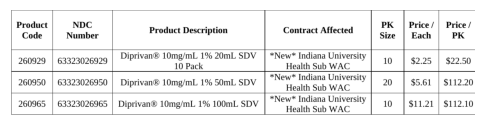

In [ ]:
# Example usage
pdf_path = filepath
page_number = 10
points = page10_dict.get("metadata").get("coordinates").get("points")

extract_and_plot_area(pdf_path, page_number, points)


* Element index 95 corresponds to page 9 in pdf

In [ ]:
page9_dict= new_elements[95].to_dict()

text_as_html9 = page9_dict.get("metadata").get("text_as_html")
display(HTML(text_as_html9))

600929,I,Health,. BallMem oral,"2401 Unwersity Drive, Muncie, IN 47303",AB2645464,42110086
600066,IU,Health Bbom,ngton,"2651 E Discovery Pkwy, Blbom ngton, IN | 47408",AB2687284 |,0GJ71Q X00
70385001,,TU Health,. Methodist,"1701 N Senate Bld, Indanapols, IN 46206",BC5175535 |,FED2VTW F3
403914,,WU Health,Saxony,"13000 136th Street, Fishers, IN 46037",FI2888115 |,98G43HLOO
400528016 |,@,Heath Shared,. Serves y,"390 Ajirtech Pkwy Suite | “10968, Phnfel, IN 46168-7455",FI2501751 |,D874BGN00
66279601,,. IU Health,. Unwversity,"550 N Unwersity Bld, Ind‘anapols, IN 46202",BC5175561,| BERMLH600
736370,. Riky,. Hospitalfor at IU,. Chiliren Health,"705 Riky Hospital | 5 ve, indianapolis, IN | 46202",BC5175511,
40052807,IU,Health Hem Pham,Onc - East acy,"6845 Rama Drwe, Ind‘anapols, IN 46219",BA3876438,L2ARED FF2
40052808,,TU Health Hem Fishers,Onc - Pharm acy,"10212 Lantem Drwe, Fishers, IN 46037",BW 8232477,| E4FLICDF1
748974,,IU Health,Morgan,"2209 John R W ooden Drive, Martnsvilk, IN 46151",FI5116682 |,422H2KBF1


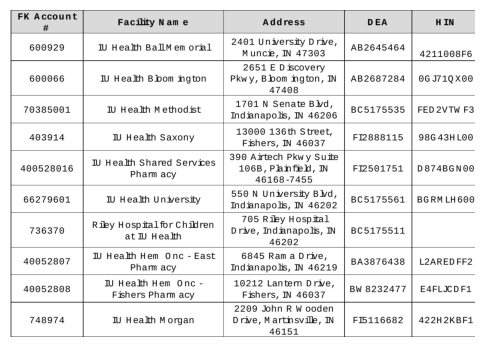

In [ ]:
page_number = 9
points = page9_dict.get("metadata").get("coordinates").get("points")

extract_and_plot_area(pdf_path, page_number, points)


* Consolidating relevant contents from pages with tables

In [ ]:
select_content_from_tables= []
for page in select_pages_with_tables:
  page= page.to_dict()
  # select_content_from_tables.append((page.get("metadata").get("filename"),
  #                                    page.get("metadata").get("text_as_html"),
  #                                    page.get("text")))
  select_content_from_tables.append((page.get("metadata").get("filename"),
                                     page.get("text")))
select_content_from_tables

[('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf',
  'FK Account # Facility Name 600929 IU Health Ball Memorial 600066 IU Health Bloomington 70385001 IU Health Methodist 403914 IU Health Saxony 400528016 IU Health Shared Services Pharmacy 66279601 IU Health University 736370 Riley Hospital for Children at IU Health 40052807 IU Health Hem Onc - East Pharmacy 40052808 IU Health Hem Onc - Fishers Pharmacy 748974 IU Health Morgan Address 2401 University Drive, Muncie, IN 47303 2651 E Discovery Pkwy, Bloomington, IN 47408 1701 N Senate Blvd, Indianapolis, IN 46206 13000 136th Street, Fishers, IN 46037 390 Airtech Pkwy Suite 106B, Plainfield, IN 46168-7455 550 N University Blvd, Indianapolis, IN 46202 705 Riley Hospital Drive, Indianapolis, IN 46202 6845 Rama Drive, Indianapolis, IN 46219 10212 Lantern Drive, Fishers, IN 46037 2209 John R Wooden Drive, Martinsville, IN 46151 DEA HIN AB2645464 BC5175511 BA3876438 BW8232477 E4FLJCDF1'),
 ('fully execute

* Simple Prompting without RAG

In [ ]:
# From phi-3 documentation

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer)


configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
query= f"""Here's the context text given as list of tuple for you to remember and understand "{select_content_from_tables}".
In the list go through each tuple containing products and pricing details, each tuple essentially contains 3 values, filename(.pdf/.txt),
table with product & pricing details in HTML as text, ONLY text from the same table at index 2 without HTML tags.
Now return all the asked details from each tuple as list of tuples in this specific format - [(filename, NDC number of each item, Price in USD of each item)].
Ensure that each output tuple in the list is of length 3 and contains these EXACTLY 3 values, 1. 'file_name' from each tuple you are referring to.,
 2. NDC number of each product/item inside each tuple, 3. Price of each item in USD.
 Here is what an example output would look like - [(filename_abc.txt, 00232-49999-10, $15),
 (filename_abc.txt, 00232-49999-11, $17), (filename_abc.txt, 00232-49999-16, $25). . .(filename_xyz.txt, 00232-4967-10, $21)].
 Fetch all the values from each given list of tuples as list of tuples.
 ..

 NOTE: UNDERSTAND THE CONTENT OF THE INPUT LIST OF TUPLES TO USE ITS DETAILS IN THE OUTPUT, RETURN THE OUTPUT NOT THE PYTHON CODE AND STRICLTY STICK THE OUTPUT FORMAT EXPLAINED AND DO NOT MAKE UP STUFF OF YOUR OWN"""
query

'Here\'s the context text given as list of tuple for you to remember and understand "[(\'fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf\', \'<table><thead><th>FK Account #</th><th></th><th>Facility</th><th>Name</th><th>Address</th><th>DEA</th><th>HIN</th></thead><tr><td>600929</td><td>I</td><td>Health</td><td>. BallMem oral</td><td>2401 Unwersity Drive, Muncie, IN 47303</td><td>AB2645464</td><td>42110086</td></tr><tr><td>600066</td><td>IU</td><td>Health Bbom</td><td>ngton</td><td>2651 E Discovery Pkwy, Blbom ngton, IN | 47408</td><td>AB2687284 |</td><td>0GJ71Q X00</td></tr><tr><td>70385001</td><td></td><td>TU Health</td><td>. Methodist</td><td>1701 N Senate Bld, Indanapols, IN 46206</td><td>BC5175535 |</td><td>FED2VTW F3</td></tr><tr><td>403914</td><td></td><td>WU Health</td><td>Saxony</td><td>13000 136th Street, Fishers, IN 46037</td><td>FI2888115 |</td><td>98G43HLOO</td></tr><tr><td>400528016 |</td><td>@</td><td>Heath Shared</td><td>. Serves y<

In [ ]:
generation_args = {
    "max_new_tokens": 512,
    "return_full_text": False,
    "temperature": 0.1,
    "do_sample": False,
}

messages = [
    {"role": "user", "content": query},
]
output = pipe(messages, **generation_args)
print(output[0]['generated_text'])

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 [(('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '<table><tr><td>FK Account #</td><td></td><td>I</td><td>Health</td><td>Ball Memorial</td><td>Indianapolis, IN 47303</td><td>HIN</td></tr><tr><td>600929</td><td>I</td><td>IU Health</td><td>Bloomington</td><td>IN 44005</td><td>6251 E Discovery Pkwy, Bloomington, IN 47408</td><td>AB2644501</td></tr><tr><td>600066</td><td>I</td><td>IU Health</td><td>Bloomington</td><td>IN 46202</td><td>1701 N Senate Blvd, Indianapolis, IN 46202</td><td>AB2645464</td></tr><tr><td>703830</td><td>R</td><td>IU Health</td><td>Chilren's</td><td>Indianapolis, IN 46206</td><td>705 Riley Hospital Drwe, Indianapolis, IN 46202</td><td>| BLERMBAL</td></tr><tr><td>66279601</td><td></td><td>IU Health</td><td>Ulrich</td><td>Indianapolis, IN 46202</td><td>570 Riley Hospital Drwe, Indianapolis, IN 46192</td><td>BC517511</td></tr><tr><td>403914</td><td>H</td><td>WU Health</td><td>Saxony</td><td>Indianapolis, IN 46219</td><td>1300


### Building rag from above context

In [ ]:
maindir= "pharmacy_contracts"
text=""
text_filepath= os.path.join(maindir, "tables_textfiles")
if not os.path.exists(text_filepath):
  print(f"{text_filepath} doesn't exist!\nCreating now. .")
  os.mkdir(text_filepath)
output_file_path= os.path.join(text_filepath, "tables_textfiles.txt")
with open(output_file_path, 'w', encoding='utf-8') as text_file:
  text+=str(select_content_from_tables)
  text_file.write(text)
  text_file.close()
  print(f"Saving textfile: {output_file_path}")

Saving textfile: pharmacy_contracts/tables_textfiles/tables_textfiles.txt


In [ ]:
system_prompt = """<|SYSTEM|>You are a Q&A assistant Expert in analyzing legal contracts and Procurement.
<|end|>\n
"""

query_wrapper_prompt= ("<|SYSTEM|>\n"
"You are a Q&A assistant Expert in analyzing legal contracts<|end|>\n"
"<|user|>\n"
"{query_str}<|end|>\n"
"<|assistant|>\n")

In [ ]:
llm = HuggingFaceLLM(
    context_window=4096,
    max_new_tokens=512,# Increase this to 4096
    generate_kwargs={"temperature": 0.7, "do_sample": True},
    # generate_kwargs={"temperature": 0.7, "do_sample": False},
    system_prompt=system_prompt,
    query_wrapper_prompt=query_wrapper_prompt,
    tokenizer_name="microsoft/Phi-3-mini-4k-instruct",
    model_name="microsoft/Phi-3-mini-4k-instruct",
    device_map="auto",
    # stopping_ids=[50278, 50279, 50277, 1, 0],
    tokenizer_kwargs={"max_length": 4096},
    # uncomment this if using CUDA to reduce memory usage
    model_kwargs={"torch_dtype": torch.float16})

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
Settings.llm = llm
Settings.chunk_size = 512
embed_model = FastEmbedEmbedding(model_name="BAAI/bge-small-en-v1.5")
Settings.embed_model = embed_model
Settings.chunk_size = 512

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
text_filepath, os.listdir(text_filepath)

('pharmacy_contracts/tables_textfiles', ['tables_textfiles.txt'])

In [ ]:
documents = SimpleDirectoryReader(text_filepath).load_data()
index = VectorStoreIndex.from_documents(documents, show_progress=True)
query_engine = index.as_query_engine()

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
query= """Understand and remember the given text in the document with products and pricing details given to you as list of tuples.
I'm looking for NDC numbers(a number with 11 to 12 digits) of products and their prices in USD. In the text, go through each tuple in the list, each tuple essentially contains 2 values - 1. filename(.pdf/.txt),
2. Text extracted from an HTML table without any HTML tags.
Go through each tuple to pick ONLY the tuples that contain text with NDC Numbers, Product/Item details and their prices in USD, these can be termed as QUALIFYING tuples with relevant tables.
IGNORE the tuples with table having no such relevant details(i.e, IGNORE Tuples that don't QUALIFY).

"NDC Number" of products/items and their corresponding "Price" in USD are to be extracted from the tables of QUALIFYING tuple ONLY.
IF QUALIFYING table is found in any tuple in the list, Obtain these 2 details from it - NDC Number(Check, it MUST be 11 to 12 digits) & Price in USD from the table at index 2 of the tuple.

Print out all the values as list of tuples in this format - [(filename, NDC number, Price in USD)].
Ensure that each tuple in the output list is of length 3 and contains EXACTLY these 3 values ONLY, 1. 'file_name' from each QUALIFYING tuple you are referring to.,
2. NDC Number(MUST BE A NUMBER with 11 to 12 digits) of each product/item in a table from QUALIFYING tuple., 3. Price of each item in USD in a table from QUALIFYING tuple.
Here is what an example output would look like - [(filename_abc.txt, 662324999910, $15),
(filename_abc.txt, 302324999911, $17), (filename_abc.txt, 562324999916, $25). . .(filename_xyz.txt, 12232496710, $21)].

Note: Return all the tuples from each text contained inside the tuples of the given list, in the text document. If you don't find any relevant details don't make up imaginary stuff."""

print(f"\nInput query: {query}\n_____\n", )

response = query_engine.query(query)
print(response)


Input query: Understand and remember the given text in the document with products and pricing details given to you as list of tuples.
I'm looking for NDC numbers(a number with 11 to 12 digits) of products and their prices in USD. In the text, go through each tuple in the list, each tuple essentially contains 2 values - 1. filename(.pdf/.txt),
2. Text extracted from an HTML table without any HTML tags.
Go through each tuple to pick ONLY the tuples that contain text with NDC Numbers, Product/Item details and their prices in USD, these can be termed as QUALIFYING tuples with relevant tables.
IGNORE the tuples with table having no such relevant details(i.e, IGNORE Tuples that don't QUALIFY).

"NDC Number" of products/items and their corresponding "Price" in USD are to be extracted from the tables of QUALIFYING tuple ONLY.
IF QUALIFYING table is found in any tuple in the list, Obtain these 2 details from it - NDC Number(Check, it MUST be 11 to 12 digits) & Price in USD from the table at in

In [ ]:
# query= """Understand and remember the given text in the document with products and pricing details given to you as list of tuples.
# I'm looking for NDC numbers(a number with 11 to 12 digits) of products and their prices in USD. In the text, go through each tuple in the list, each tuple essentially contains 2 values - 1. filename(.pdf/.txt),
# 2. Text extracted from an HTML table without any HTML tags.
# Go through each tuple to pick ONLY the tuples that contain tables with NDC Numbers, Product/Item details and their prices in USD, these can be termed as QUALIFYING tuples with relevant tables.
# IGNORE the tuples with table having no such relevant details(i.e, IGNORE Tuples that don't QUALIFY).

# "NDC Number" of products/items and their corresponding "Price" in USD are to be extracted from the tables of QUALIFYING tuple ONLY.
# IF QUALIFYING table is found in any tuple in the list, Obtain these 2 details from it - NDC Number(Check, it MUST be 11 to 12 digits) & Price in USD from the table at index 2 of the tuple.

# Print out all the values as list of tuples in this format - [(filename, NDC number, Price in USD)].
# Ensure that each tuple in the output list is of length 3 and contains EXACTLY these 3 values ONLY, 1. 'file_name' from each QUALIFYING tuple you are referring to.,
# 2. NDC Number(MUST BE A NUMBER with 11 to 12 digits) of each product/item in a table from QUALIFYING tuple., 3. Price of each item in USD in a table from QUALIFYING tuple.
# Here is what an example output would look like - [(filename_abc.txt, 662324999910, $15),
# (filename_abc.txt, 302324999911, $17), (filename_abc.txt, 562324999916, $25). . .(filename_xyz.txt, 12232496710, $21)].

# Note: Return all the tuples from each text contained inside the tuples of the given list, in the text document. If you don't find any relevant details don't make up imaginary stuff."""

# print(f"\nInput query: {query}\n_____\n", )

# response = query_engine.query(query)
# print(response)


Input query: Understand and remember the given text in the document with products and pricing details given to you as list of tuples.
I'm looking for NDC numbers(a number with 11 to 12 digits) of products and their prices in USD. In the text, go through each tuple in the list, each tuple essentially contains 2 values - 1. filename(.pdf/.txt),
2. Text extracted from an HTML table without any HTML tags.
Go through each tuple to pick ONLY the tuples that contain tables with NDC Numbers, Product/Item details and their prices in USD, these can be termed as QUALIFYING tuples with relevant tables.
IGNORE the tuples with table having no such relevant details(i.e, IGNORE Tuples that don't QUALIFY).

"NDC Number" of products/items and their corresponding "Price" in USD are to be extracted from the tables of QUALIFYING tuple ONLY.
IF QUALIFYING table is found in any tuple in the list, Obtain these 2 details from it - NDC Number(Check, it MUST be 11 to 12 digits) & Price in USD from the table at 

In [ ]:
# query= """Understand and remember the given text in the document with products and pricing details given to you as list of tuples.
# I'm looking for NDC numbers(11 to 12 digits) of products and their prices in USD. In the text, go through each tuple in the list, each tuple essentially contains 3 values - 1. filename(.pdf/.txt),
# 2. A table in HTML format, 3. text obtained from the same table at 2. but without any HTML tags.
# Go through each tuple to pick ONLY the tuples that contain tables with NDC Numbers, Product/Item details and their prices in USD, these can be termed as QUALIFYING tuples with relevant tables.
# IGNORE the tuples with table having no such relevant details(i.e, IGNORE Tuples that don't QUALIFY).

# NDC numbers of products/items and their corresponding prices in USD are to be extracted from the tables of QUALIFYING tuple ONLY.
# IF QUALIFYING table is found in any tuple in the list, Obtain these details - NDC number(with 11 to 12 digits) & Price in USD from the table at index 2 of the tuple,
# You can also refer to the text given at 3. in the same tuple for clarifiying details.

# Print out all the values as list of tuples in this format - [(filename, NDC number, Price in USD)].
# Ensure that each tuple in the output list is of length 3 and contains EXACTLY these 3 values ONLY, 1. 'file_name' from each QUALIFYING tuple you are referring to.,
# 2. A 11 to 12 digits NDC Number of each product/item in a table from QUALIFYING tuple., 3. Price of each item in USD in a table from QUALIFYING tuple.
# Here is what an example output would look like - [(filename_abc.txt, 002324999910, $15),
# (filename_abc.txt, 002324999911, $17), (filename_abc.txt, 002324999916, $25). . .(filename_xyz.txt, 00232496710, $21)].
# Ensure that the tuples in output list contain only formatted simple string but NOT any HTML tags from the original table of QUALIFYING tuple.
# Also check the NDC numbers must have length of 11 to 12 digits.

# Note: Return all the tuples from each table contained inside the tuples of the given list in the text document. If you don't find any relevant details don't make up imaginary stuff."""

# print(f"\nInput query: {query}\n_____\n", )

# response = query_engine.query(query)
# print(response)


Input query: Understand and remember the given text in the document with products and pricing details given to you as list of tuples.
I'm looking for NDC numbers(11 to 12 digits) of products and their prices in USD. In the text, go through each tuple in the list, each tuple essentially contains 3 values - 1. filename(.pdf/.txt),
2. A table in HTML format, 3. text obtained from the same table at 2. but without any HTML tags.
Go through each tuple to pick ONLY the tuples that contain tables with NDC Numbers, Product/Item details and their prices in USD, these can be termed as QUALIFYING tuples with relevant tables.
IGNORE the tuples with table having no such relevant details(i.e, IGNORE Tuples that don't QUALIFY).

NDC numbers of products/items and their corresponding prices in USD are to be extracted from the tables of QUALIFYING tuple ONLY.
IF QUALIFYING table is found in any tuple in the list, Obtain these details - NDC number(with 11 to 12 digits) & Price in USD from the table at in

In [ ]:
# query= """Understand and remember the given text in the document with products and pricing details given to you as list of tuples.
# I'm looking for NDC numbers of products and their prices in USD. In the text, go through each tuple in the list, each tuple essentially contains 3 values - 1. filename(.pdf/.txt),
# 2. A table in HTML format, 3. text obtained from the same table at 2. but without any HTML tags.
# Go through each tuple to pick ONLY the tuples that contain tables with NDC Numbers, Product/Item details and their prices in USD, these can be termed as QUALIFYING tuples with relevant tables.
# IGNORE the tuples with table having no such relevant details(i.e, IGNORE Tuples that don't QUALIFY).

# The NDC numbers and their prices in USD are to be extracted from the tables of QUALIFYING tuple ONLY.
# IF QUALIFYING table is found in any tuple in the list, Obtain these details - NDC number & Price in USD from the table at index 2 of the tuple,
# You can also refer to the text given at 3. in the same tuple for clarifiying details.

# Print out all the values as list of tuples in this format - [(filename, NDC number, Price in USD)].
# Ensure that each tuple in the output list is of length 3 and contains EXACTLY these 3 values ONLY, 1. 'file_name' from each QUALIFYING tuple you are referring to.,
# 2. An 11 digits NDC number of each product/item in a table from QUALIFYING tuple., 3. Price of each item in USD in a table from QUALIFYING tuple.
# Here is what an example output would look like - [(filename_abc.txt, 00232-49999-10, $15),
# (filename_abc.txt, 00232-49999-11, $17), (filename_abc.txt, 00232-49999-16, $25). . .(filename_xyz.txt, 00232-4967-10, $21)].
# Ensure that the tuples in output list contain only formatted simple string but NOT any HTML tags from the original table of QUALIFYING tuple.

# Note: Return all the tuples from each table contained inside the tuples of the given list in the text document. If you don't find any relevant details don't make up imaginary stuff."""

# print(f"\nInput query: {query}\n_____\n", )

# response = query_engine.query(query)
# print(response)


Input query: Understand and remember the given text in the document with products and pricing details given to you as list of tuples.
I'm looking for NDC numbers of products and their prices in USD. In the text, go through each tuple in the list, each tuple essentially contains 3 values - 1. filename(.pdf/.txt),
2. A table in HTML format, 3. text obtained from the same table at 2. but without any HTML tags.
Go through each tuple to pick ONLY the tuples that contain tables with NDC Numbers, Product/Item details and their prices in USD, these can be termed as QUALIFYING tuples with relevant tables.
IGNORE the tuples with table having no such relevant details(i.e, IGNORE Tuples that don't QUALIFY).

The NDC numbers and their prices in USD are to be extracted from the tables of QUALIFYING tuple ONLY.
IF QUALIFYING table is found in any tuple in the list, Obtain these details - NDC number & Price in USD from the table at index 2 of the tuple, 
You can also refer to the text given at 3. in 

In [ ]:
# query= """Understand and remember the given text in the document with products and pricing details given to you as list of tuples.
# I'm looking for NDC numbers of products and their prices in USD. In the text, go through each tuple in the list, each tuple essentially contains 3 values - 1. filename(.pdf/.txt),
# 2. A table in HTML format, 3. text obtained from the same table at 2. but without any HTML tags.
# Go through each tuple to pick ONLY the tuples that contain tables with NDC Numbers, Product/Item details and their prices in USD, these can be termed as QUALIFYING tuples with relevant tables.
# IGNORE the tuples with table having no such relevant details(i.e, IGNORE Tuples that don't QUALIFY).

# The NDC numbers and their prices in USD are to be extracted from the tables of QUALIFYING tuple ONLY.
# IF QUALIFYING table is found in any tuple in the list, Obtain these details - NDC number & Price in USD from the table at index 2 of the tuple,
# You can also refer to the text given at 3. in the same tuple for clarifiying details.

# Print out all the values as list of tuples in this format - [(filename, NDC number, Price in USD)].
# Ensure that each tuple in the output list is of length 3 and contains EXACTLY these 3 values ONLY, 1. 'file_name' from each QUALIFYING tuple you are referring to.,
# 2. NDC number of each product/item in a table from QUALIFYING tuple., 3. Price of each item in USD in a table from QUALIFYING tuple.
# Here is what an example output would look like - [(filename_abc.txt, 00232-49999-10, $15),
# (filename_abc.txt, 00232-49999-11, $17), (filename_abc.txt, 00232-49999-16, $25). . .(filename_xyz.txt, 00232-4967-10, $21)].
# Ensure that the tuples in output list contain only formatted simple string but NOT any HTML tags from the original table of QUALIFYING tuple.

# Note: Return all the tuples from each table contained inside the tuples of the given list in the text document. If you don't find any relevant details don't make up imaginary stuff."""

# print(f"\nInput query: {query}\n_____\n", )

# response = query_engine.query(query)
# print(response)


Input query: Understand and remember the given text in the document with products and pricing details given to you as list of tuples. 
In the text, go through each tuple in the list, each tuple essentially contains 3 values - 1. filename(.pdf/.txt), 
2. An HTML format table as text with product & pricing details, 3. text obtained from the same table at 2. but without HTML tags.
Obtain the details like NDC number & Price in USD from the table at 2., you can also refer to text given at 3. for clarifiying details.

Print out all the values as list of tuples in this format - [(filename, NDC number, Price in USD)].
Ensure that each tuple in the output list is of length 3 and contains EXACTLY these 3 values ONLY, 1. 'file_name' from each tuple you are referring to.,
2. NDC number of each product/item in a table inside each tuple., 3. Price of each item in USD in a table inside each tuple.
Here is what an example output would look like - [(filename_abc.txt, 00232-49999-10, $15),
(filename_ab

You are not running the flash-attention implementation, expect numerical differences.


[(('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '600929', '$N/A'),
 ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '600066', '$N/A'),
 ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '70385001', '$N/A'),
 ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '403914', '$N/A'),
 ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '400528016', '$N/A'),
 ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '66279601', '$N/A'),
 ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '736370', '$N/A'),
 ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '40052807', '$N/A'),
 ('fully executed FK Pharma Sub-WAC Purchase Agreement IU Subwac eff 2.1.2024 (final).pdf', '40052808'

In [ ]:
# query= f"""Here's the context text given as list of tuple for you to remember and understand "{select_content_from_tables}".
# In the list go through each tuple containing products and pricing details, each tuple essentially contains 3 values, filename(.pdf/.txt),
# table with product & pricing details in HTML as text, ONLY text from the same table at index 2 without HTML tags.
# Now return all the asked details from each tuple as list of tuples in this specific format - [(filename, NDC number of each item, Price in USD of each item)].
# Ensure that each output tuple in the list is of length 3 and contains these EXACTLY 3 values, 1. 'file_name' from each tuple you are referring to.,
#  2. NDC number of each product/item inside each tuple, 3. Price of each item in USD.
#  Here is what an example output would look like - [(filename_abc.txt, 00232-49999-10, $15),
#  (filename_abc.txt, 00232-49999-11, $17), (filename_abc.txt, 00232-49999-16, $25). . .(filename_xyz.txt, 00232-4967-10, $21)].
#  Fetch all the values from each given list of tuples as list of tuples.
#  ..

#  NOTE: UNDERSTAND THE CONTENT OF THE INPUT LIST OF TUPLES TO USE ITS DETAILS IN THE OUTPUT, RETURN THE OUTPUT NOT THE PYTHON CODE AND STRICLTY STICK THE OUTPUT FORMAT EXPLAINED AND DO NOT MAKE UP STUFF OF YOUR OWN"""



## Last query
# query= """Understand and remember the given text in the document with products and pricing details given to you as list of tuples.
# In the text, go through each tuple in the list, each tuple essentially contains 3 values - 1. filename(.pdf/.txt),
# 2. An HTML format table as text with product & pricing details, 3. text obtained from the same table at 2. but without HTML tags.
# Obtain the details like NDC number & Price in USD from the table at 2., you can also refer to text given at 3. for clarifiying details.

# Print out all the values as list of tuples in this format - [(filename, NDC number, Price in USD)].
# Ensure that each tuple in the output list is of length 3 and contains EXACTLY these 3 values ONLY, 1. 'file_name' from each tuple you are referring to.,
# 2. NDC number of each product/item in a table inside each tuple., 3. Price of each item in USD in a table inside each tuple.
# Here is what an example output would look like - [(filename_abc.txt, 00232-49999-10, $15),
# (filename_abc.txt, 00232-49999-11, $17), (filename_abc.txt, 00232-49999-16, $25). . .(filename_xyz.txt, 00232-4967-10, $21)].
# Ensure the tuples in output list contain only formatted simple string but NOT any HTML tags of the original table.

# Note: Return all the tuples from each table contained inside the tuples of the given list in the text document. If you don't find any relevant details don't make up imaginary stuff."""